In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, sampler
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import PIL
PIL.Image.MAX_IMAGE_PIXELS = None
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [2]:
# Only run once, don't rerun in same runtime
%cd drive/My\ Drive/final_project
!pwd


/content/drive/My Drive/final_project
/content/drive/My Drive/final_project


In [6]:
device = torch.device("cuda" if torch.cuda.is_available()
                               else "cpu")
print("We are using: ", device)

We are using:  cuda


In [3]:
img_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ])

data = datasets.ImageFolder(root ="./data-new",  transform = img_transforms)


data_indices = list(range(len(data)))[:16696] # class imbalance bc 8348 ads and 13597 non ads, so we resize to 8348 ads and 8348 nonads
# ad, non_ad = data_indices[:8348], data_indices[8348:]
# data_indices = ad[:5000] + non_ad[:5000] 

print(len(data_indices))
np.random.shuffle(data_indices)
# 70/15/15 split for train/val/test
val_split_index = len(data_indices) - int(np.floor(0.30 * len(data_indices)))
test_split_index = len(data_indices) - int(np.floor(0.15 * len(data_indices)))

print("val split index: ", val_split_index)
print("test_split_index: ", test_split_index)

train_idx = data_indices[: val_split_index]
val_idx = data_indices[val_split_index: test_split_index]
test_idx = data_indices[test_split_index:]

print("len train: ", len(train_idx))
print("len val: ", len(val_idx))
print("len test: ", len(test_idx))

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(dataset=data, shuffle=False, batch_size=64, sampler=train_sampler, num_workers=4)
val_loader = DataLoader(dataset=data, shuffle=False, batch_size=64, sampler=val_sampler, num_workers=4)
test_loader = DataLoader(dataset=data,shuffle=False, batch_size=64, sampler=test_sampler, num_workers=4)

data.class_to_idx.items()


16696
val split index:  11688
test_split_index:  14192
len train:  11688
len val:  2504
len test:  2504


dict_items([('10-resized', 0), ('resnet_training_negatives_resized', 1)])

In [0]:
# model = models.resnet34(pretrained=True) # resnet34
model = models.resnet101(pretrained=True) # resnet 101

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [0]:
# # Squeezenet (no linear layer, so we replace last conv layer w right number of classes)
# # change the last conv2d layer
# model = models.squeezenet1_0(pretrained=True) 
# model.classifier._modules["1"] = nn.Conv2d(512, 2, kernel_size=(1, 1))
# # change the internal num_classes variable rather than redefining the forward pass
# model.num_classes = 2

In [0]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.008)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5



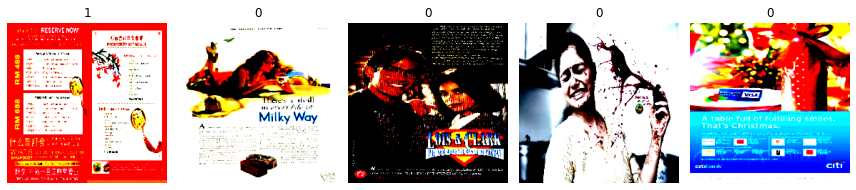

In [32]:
test_loader = DataLoader(dataset=data,shuffle=False, batch_size=5, sampler=test_sampler)
y_pred_list = []
y_true_list = []
X_list=[]
with torch.no_grad():
    for X, y in tqdm(test_loader):
        print(len(X))
        # y_test_pred = model(X)
        
        X, y = X.to(device), y.to(device)
        X=X.cpu().numpy()
        # X_list.append(X.cpu().numpy())
        
        # y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        # _, y_pred_tag = torch.max(y_test_pred, dim = 1)
    
        # y_pred_list.append(y_pred_tag.cpu().numpy())
        y=y.cpu().numpy()
        # y_true_list.append(y.cpu().numpy())
        break

# y_pred_list = [i[0] for i in y_pred_list]
# y = [i[0] for i in y_true_list]
# y = y_true_list
# X=X_list
# print(X)
# print(X.shape)
# print(np.transpose(X[0], (1, 2, 0)).shape)
X = np.transpose(X, (0,2, 3, 1))
plt.figure(figsize=(12, 6))
for i in range(5):
    # print(X[i].shape)
    # X[i] = np.transpose(X[i], (1, 2, 0))
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.axis('off')
plt.gcf().tight_layout()


In [0]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.
    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.
    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    # Make input tensor require gradient
    # torch.tensor(1, dtype=torch.float, requires_grad=True).cuda()
    X.requires_grad_()
    X.cuda()
    saliency = None
    # Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    scores = model(X).gather(1, y.view(-1, 1)).squeeze()  
    scores.backward(torch.FloatTensor([1.0, 1.0, 1.0, 1.0, 1.0]).cuda())
    saliency = X.grad.data.abs()
    saliency, i = torch.max(saliency, dim=1)
    saliency = saliency.squeeze()
    return saliency

In [0]:
import torchvision.transforms as T
SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


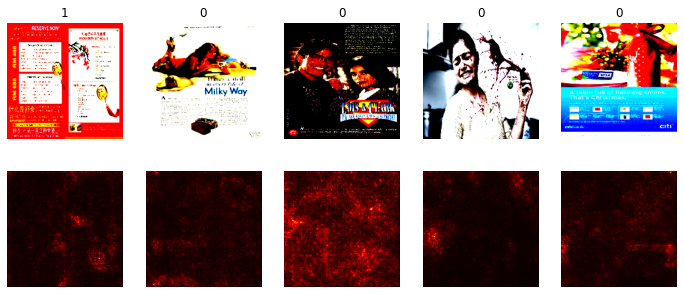

In [40]:
# def show_saliency_maps(X, y):
# Convert X and y from numpy arrays to Torch Tensors
# X, y = X.to(device), y.to(device)

X_tensor = torch.cat([preprocess(Image.fromarray((x * 255).astype(np.uint8))) for x in X], dim=0).to(device)
  
# X_tensor = torch.cat([(torch.Tensor(x)) for x in X], dim=0)
y_tensor = torch.LongTensor(y).to(device)
# inputs, labels = inputs.cuda(), labels.cuda() # add this line

# Compute saliency maps for images in X
saliency = compute_saliency_maps(X_tensor.to(device), y_tensor.to(device), model)

# Convert the saliency map from Torch Tensor to numpy array and show images
# and saliency maps together.
# y.cpu().numpy()
saliency = saliency.cpu().numpy()
N = X.shape[0]
for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(y[i])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    plt.axis('off')
    plt.gcf().set_size_inches(12, 5)
plt.show()

# show_saliency_maps(X, y)

In [0]:
def class_visualization_update_step(img, model, target_y, l2_reg, learning_rate):
    ########################################################################
    # Use the model to compute the gradient of the score for the     #
    # class target_y with respect to the pixels of the image, and make a   #
    # gradient step on the image using the learning rate. 
    ########################################################################
        scores = model(img)
        target_score = scores[0, target_y] 
        target_score.backward()
        grad = img.grad.data - (2 * l2_reg * img.data)                
        img.data += learning_rate * grad / grad.norm() 
        img.grad.data.zero_()
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

def jitter(X, ox, oy):
    """
    Helper function to randomly jitter an image.

    Inputs
    - X: PyTorch Tensor of shape (N, C, H, W)
    - ox, oy: Integers giving number of pixels to jitter along W and H axes

    Returns: A new PyTorch Tensor of shape (N, C, H, W)
    """
    if ox != 0:
        left = X[:, :, :, :-ox]
        right = X[:, :, :, -ox:]
        X = torch.cat([right, left], dim=3)
    if oy != 0:
        top = X[:, :, :-oy]
        bottom = X[:, :, -oy:]
        X = torch.cat([bottom, top], dim=2)
    return X
def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [0]:
def create_class_visualization(target_y, model, dtype, **kwargs):
    """
    Generate an image to maximize the score of target_y under a pretrained model.

    Inputs:
    - target_y: Integer in the range [0, 1000) giving the index of the class
    - model: A pretrained CNN that will be used to generate the image
    - dtype: Torch datatype to use for computations

    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    """
    model.type(dtype)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 25)
    num_iterations = kwargs.pop('num_iterations', 100)
    blur_every = kwargs.pop('blur_every', 10)
    max_jitter = kwargs.pop('max_jitter', 16)
    show_every = kwargs.pop('show_every', 25)

    # Randomly initialize the image as a PyTorch Tensor, and make it requires gradient.
    img = torch.randn(1, 3, 224, 224).mul_(1.0).type(dtype).requires_grad_()

    for t in range(num_iterations):
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = random.randint(0, max_jitter), random.randint(0, max_jitter)
        img.data.copy_(jitter(img.data, ox, oy))
        class_visualization_update_step(img, model, target_y, l2_reg, learning_rate)
        # Undo the random jitter
        img.data.copy_(jitter(img.data, -ox, -oy))

        # As regularizer, clamp and periodically blur the image
        for c in range(3):
            lo = float(-SQUEEZENET_MEAN[c] / SQUEEZENET_STD[c])
            hi = float((1.0 - SQUEEZENET_MEAN[c]) / SQUEEZENET_STD[c])
            img.data[:, c].clamp_(min=lo, max=hi)
        if t % blur_every == 0:
            blur_image(img.data, sigma=0.5)

        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            plt.imshow(deprocess(img.data.clone().cpu()))
            # class_name = class_names[target_y]
            plt.title('%s\nIteration %d / %d' % (target_y, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()

    return deprocess(img.data.cpu())

NON AD


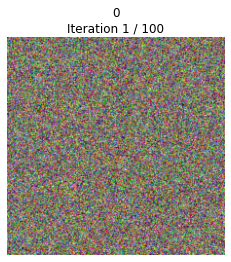

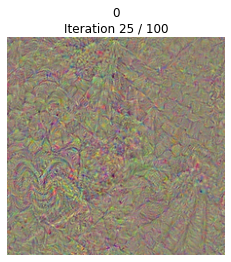

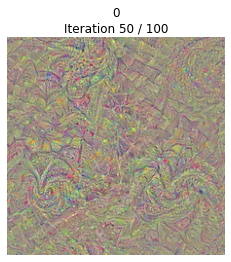

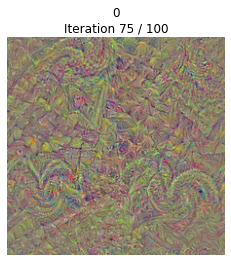

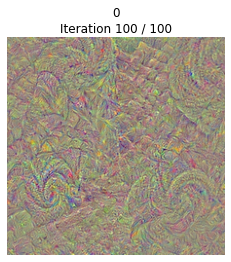

AD


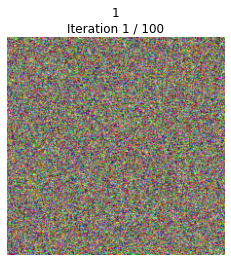

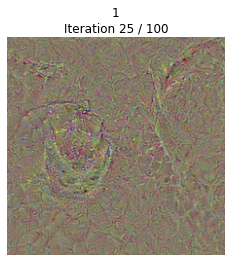

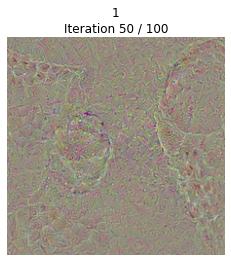

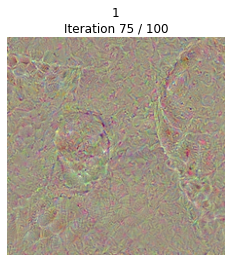

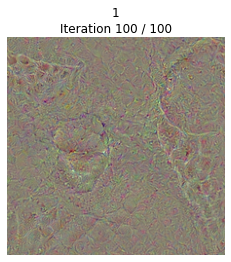

In [54]:
import random
from scipy.ndimage.filters import gaussian_filter1d

dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to use GPU
model.type(dtype)

print("NON AD")
target_y = 0 # non ad
out = create_class_visualization(target_y, model, dtype)

print("AD")

target_y = 1 # ad
out = create_class_visualization(target_y, model, dtype)